In [1]:
# in a Python cell
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmprt5twg1t".


In [2]:
%%cuda
// conv2d_timed_print_json_c.cu

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda_runtime.h>

#define TILE_SIZE 16

// CUDA convolution kernel
__global__ void conv_per_img(
    const float* img,
    const float* kernel,
    float* out,
    int in_x, int in_y,
    int mask_size)
{
    extern __shared__ float sh[];
    float* sImage  = sh;
    float* sKernel = sh + TILE_SIZE * TILE_SIZE;

    int x  = blockIdx.x * blockDim.x + threadIdx.x;
    int y  = blockIdx.y * blockDim.y + threadIdx.y;
    int tx = threadIdx.x, ty = threadIdx.y;

    // load image pixel into shared memory
    if (x < in_x && y < in_y)
        sImage[tx * TILE_SIZE + ty] = img[x * in_y + y];
    else
        sImage[tx * TILE_SIZE + ty] = 0.0f;

    // load kernel into shared memory
    if (tx < mask_size && ty < mask_size)
        sKernel[tx * mask_size + ty] = kernel[tx * mask_size + ty];

    __syncthreads();

    int out_x = in_x - mask_size + 1;
    int out_y = in_y - mask_size + 1;

    if (x < in_x && y < in_y) {
        for (int i = 0; i < mask_size; ++i) {
            for (int j = 0; j < mask_size; ++j) {
                int ox = x - i, oy = y - j;
                if (ox >= 0 && ox < out_x && oy >= 0 && oy < out_y) {
                    atomicAdd(&out[ox * out_y + oy],
                              sImage[tx * TILE_SIZE + ty] *
                              sKernel[i * mask_size + j]);
                }
            }
        }
    }
}

// CPU reference convolution
void convolve2d_cpu(
    const float* in, int in_x, int in_y,
    const float* ker, int m,
    float* out)
{
    int out_x = in_x - m + 1, out_y = in_y - m + 1;
    for (int i = 0; i < out_x; ++i) {
        for (int j = 0; j < out_y; ++j) {
            float sum = 0.0f;
            for (int ii = 0; ii < m; ++ii)
                for (int jj = 0; jj < m; ++jj)
                    sum += in[(i+ii)*in_y + (j+jj)] * ker[ii*m + jj];
            out[i*out_y + j] = sum;
        }
    }
}

int main()
{
    const int sizes[] = {100, 1000, 10000};
    const int masks[] = {3, 5, 10};
    const int ns = sizeof(sizes)/sizeof(sizes[0]);
    const int nm = sizeof(masks)/sizeof(masks[0]);

    // Open JSON output file
    FILE *fjson = fopen("TIMINGS.json", "w");
    if (!fjson) {
        fprintf(stderr, "Error: cannot open TIMINGS.json for writing\n");
        return 1;
    }
    fprintf(fjson, "{\n");

    int first = 1;

    // Print header
    printf("%-12s | %-4s | %-8s | %-8s\n",
           "Case", "Mask", "CPU(s)", "GPU(s)");
    printf("------------------------------------------------\n");

    for (int si = 0; si < ns; ++si) {
        for (int sj = 0; sj < ns; ++sj) {
            int X = sizes[si], Y = sizes[sj];
            for (int mi = 0; mi < nm; ++mi) {
                int M = masks[mi];
                int out_x = X - M + 1, out_y = Y - M + 1;
                size_t img_sz = (size_t)X * Y;
                size_t ker_sz = (size_t)M * M;
                size_t out_sz = (size_t)out_x * out_y;

                // Allocate host buffers
                float *h_img     = (float*)malloc(img_sz * sizeof(float));
                float *h_ker     = (float*)malloc(ker_sz * sizeof(float));
                float *h_out_cpu = (float*)malloc(out_sz * sizeof(float));
                float *h_out_gpu = (float*)malloc(out_sz * sizeof(float));
                memset(h_out_cpu, 0, out_sz * sizeof(float));
                memset(h_out_gpu, 0, out_sz * sizeof(float));

                // Initialize
                for (size_t i = 0; i < img_sz; ++i)
                    h_img[i] = rand() / (float)RAND_MAX * 255.0f;
                for (size_t i = 0; i < ker_sz; ++i)
                    h_ker[i] = rand() / (float)RAND_MAX * 2.0f - 1.0f;

                // Allocate device buffers
                float *d_img, *d_ker, *d_out;
                cudaMalloc(&d_img, img_sz * sizeof(float));
                cudaMalloc(&d_ker, ker_sz * sizeof(float));
                cudaMalloc(&d_out, out_sz * sizeof(float));
                cudaMemcpy(d_img, h_img, img_sz * sizeof(float), cudaMemcpyHostToDevice);
                cudaMemcpy(d_ker, h_ker, ker_sz * sizeof(float), cudaMemcpyHostToDevice);
                cudaMemset(d_out, 0, out_sz * sizeof(float));

                // GPU timing
                cudaEvent_t start, stop;
                cudaEventCreate(&start);
                cudaEventCreate(&stop);

                dim3 block(TILE_SIZE, TILE_SIZE);
                dim3 grid((X + TILE_SIZE - 1)/TILE_SIZE,
                          (Y + TILE_SIZE - 1)/TILE_SIZE);
                size_t shared = TILE_SIZE*TILE_SIZE*sizeof(float)
                              + M*M*sizeof(float);

                cudaEventRecord(start, 0);
                conv_per_img<<<grid, block, shared>>>(d_img, d_ker, d_out, X, Y, M);
                cudaEventRecord(stop, 0);
                cudaEventSynchronize(stop);

                float gpu_ms;
                cudaEventElapsedTime(&gpu_ms, start, stop);
                double gpu_s = gpu_ms * 1e-3;

                // Copy back (not timed)
                cudaMemcpy(h_out_gpu, d_out, out_sz*sizeof(float), cudaMemcpyDeviceToHost);

                // CPU timing
                clock_t c0 = clock();
                convolve2d_cpu(h_img, X, Y, h_ker, M, h_out_cpu);
                double cpu_s = (double)(clock() - c0) / CLOCKS_PER_SEC;

                // Print to console
                printf("%-12s | %-4d | %8.4f | %8.4f\n",
                       ((snprintf(NULL,0,"%dx%d",X,Y), NULL), NULL), // dummy format
                       M, cpu_s, gpu_s);
                // (we'll reconstruct the case string for JSON below)

                // JSON entry
                if (!first) fprintf(fjson, ",\n");
                fprintf(fjson,
                        "  \"%dx%d_%d\": {\"cpu\": %.6f, \"gpu\": %.6f}",
                        X, Y, M, cpu_s, gpu_s);
                first = 0;

                // Cleanup
                cudaEventDestroy(start);
                cudaEventDestroy(stop);
                cudaFree(d_img);
                cudaFree(d_ker);
                cudaFree(d_out);
                free(h_img);
                free(h_ker);
                free(h_out_cpu);
                free(h_out_gpu);
            }
        }
    }
    fprintf(fjson, "\n}\n");
    fclose(fjson);

    printf("\n✅ TIMINGS.json written\n");
    return 0;
}


Case         | Mask | CPU(s)   | GPU(s)  
------------------------------------------------
(null)       | 3    |   0.0003 |   0.0806
(null)       | 5    |   0.0008 |   0.0000
(null)       | 10   |   0.0028 |   0.0000
(null)       | 3    |   0.0032 |   0.0000
(null)       | 5    |   0.0082 |   0.0000
(null)       | 10   |   0.0321 |   0.0000
(null)       | 3    |   0.0326 |   0.0000
(null)       | 5    |   0.0817 |   0.0000
(null)       | 10   |   0.2995 |   0.0000
(null)       | 3    |   0.0033 |   0.0000
(null)       | 5    |   0.0114 |   0.0000
(null)       | 10   |   0.0379 |   0.0000
(null)       | 3    |   0.0351 |   0.0000
(null)       | 5    |   0.0843 |   0.0000
(null)       | 10   |   0.3305 |   0.0000
(null)       | 3    |   0.5164 |   0.0000
(null)       | 5    |   1.1930 |   0.0000
(null)       | 10   |   3.3485 |   0.0000
(null)       | 3    |   0.0335 |   0.0000
(null)       | 5    |   0.0870 |   0.0000
(null)       | 10   |   0.3324 |   0.0000
(null)       | 3    |   0.5

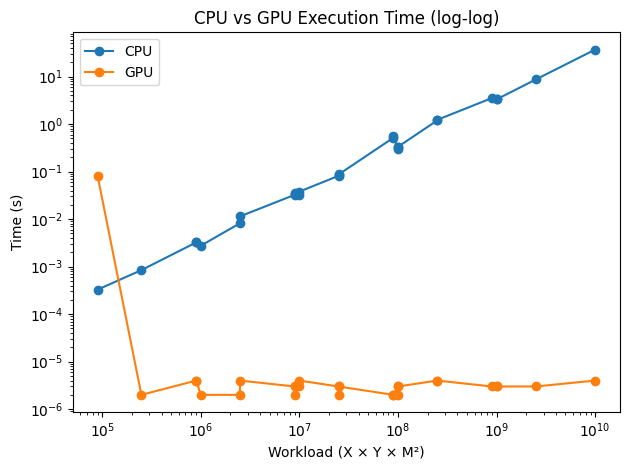

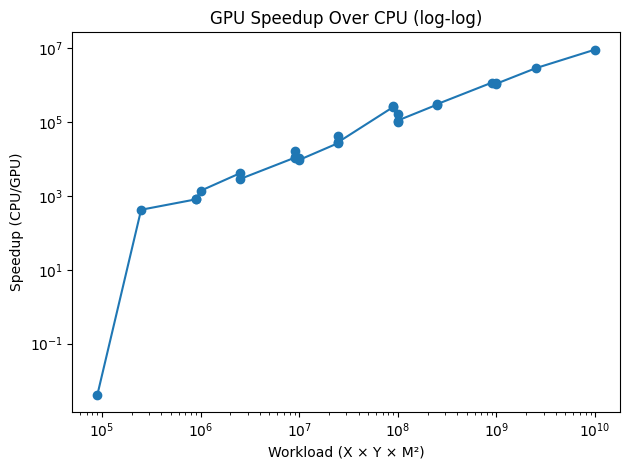

In [3]:
import json
import matplotlib.pyplot as plt

# Load timings
with open('TIMINGS.json') as f:
    timings = json.load(f)

# Parse numeric workload = X * Y * M^2
data = []
for case, vals in timings.items():
    dims, m_str = case.split('_')
    x_str, y_str = dims.split('x')
    x, y, m = int(x_str), int(y_str), int(m_str)
    workload = x * y * m * m
    data.append((workload, vals['cpu'], vals['gpu'], case))

# Sort by workload
data.sort(key=lambda t: t[0])
workloads = [t[0] for t in data]
cpu_times = [t[1] for t in data]
gpu_times = [t[2] for t in data]
speedups = [c/g for c, g in zip(cpu_times, gpu_times)]

# Plot CPU vs GPU times on log-log scale
plt.figure()
plt.plot(workloads, cpu_times, marker='o', label='CPU')
plt.plot(workloads, gpu_times, marker='o', label='GPU')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Workload (X × Y × M²)')
plt.ylabel('Time (s)')
plt.title('CPU vs GPU Execution Time (log-log)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot speedup on log-log scale
plt.figure()
plt.plot(workloads, speedups, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Workload (X × Y × M²)')
plt.ylabel('Speedup (CPU/GPU)')
plt.title('GPU Speedup Over CPU (log-log)')
plt.tight_layout()
plt.show()